При режиме работы в реальном времени, новые значения ряда $f_n$ приходят раз в какой-то промежуток времени. Для поиска неоднородности мы можем перестраивать матрицу неоднородности для каждого нового значения ряда или же достраивать, сохраняя вычисления на предыдущих шагах. В данной тетрадке тестируется время работы для обоих подходов.

In [1]:
import time
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr

from utils.hmatr import Hmatr


%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

rpy2.robjects.numpy2ri.activate()
utils = importr('utils')
utils.chooseCRANmirror(ind=1)

# utils.install_packages('Rssa')

# library(Rssa)
rssa = importr('Rssa')

D:\Program Files\anaconda\envs\researchWork\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


# Генерация рядов

Будем рассматривать ряды вида
$f_n = 
\begin{cases}
    C_1\sin(2\pi\omega_1 n),\; & n < Q-1, \\
    C_2\sin(2\pi\omega_2 n),\; & n \geq Q-1.
\end{cases} $

## Ряды на `Python`.

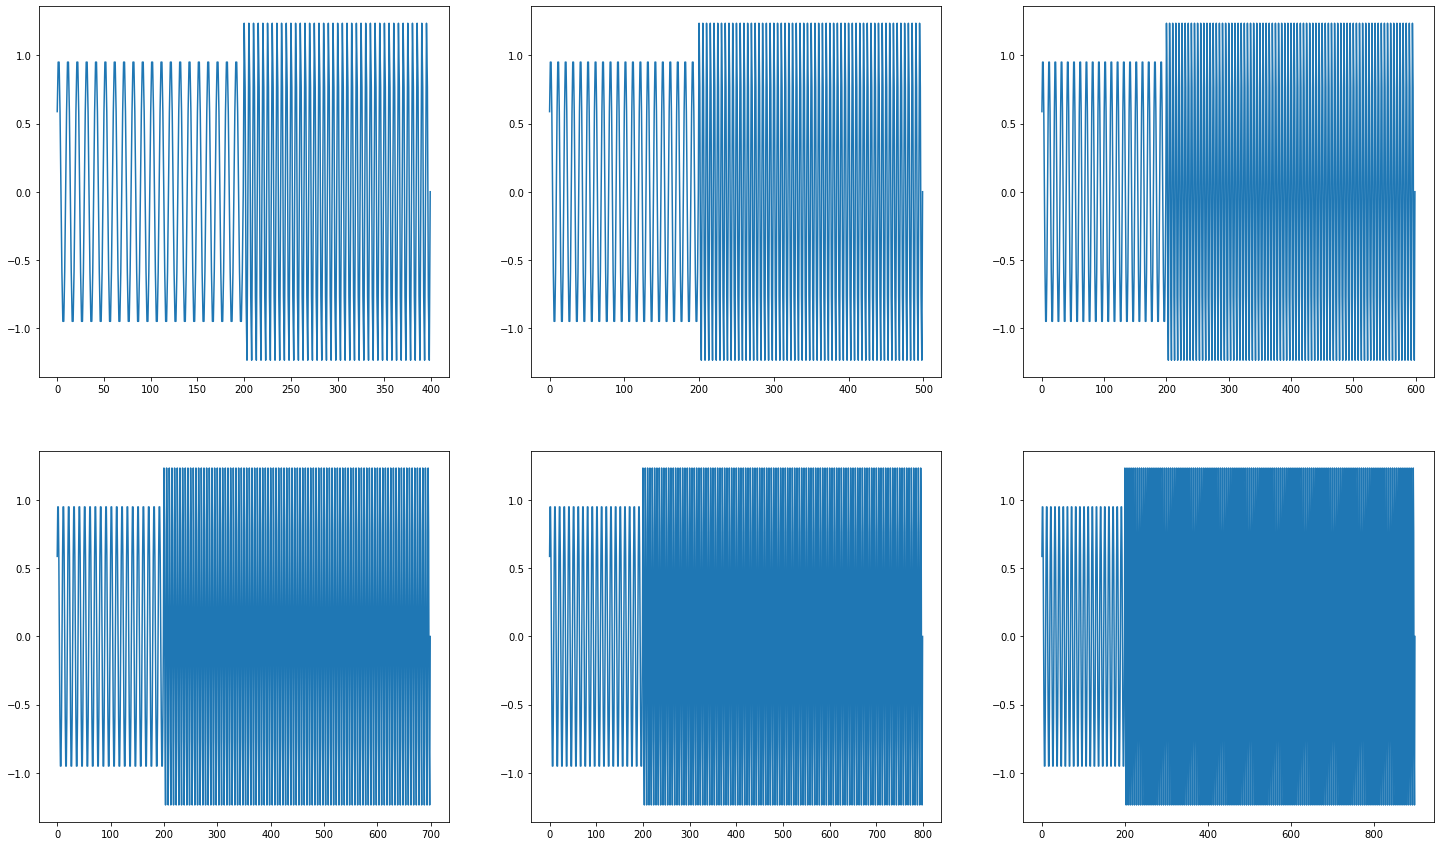

In [2]:
N = 400
w1 = 1/10
w2 = 1/5
C1 = 1
C2 = 1.3
phi1 = 0
phi2 = 0
Q = 201
B = 100
T_ = 100
L = 50
r = 5

method = "nutrlan"

series = lambda n: C1*np.sin(2*np.pi*w1*n + phi1) if n < Q-1 else C2*np.sin(2*np.pi*w2*n + phi2)

f = [series(i) for i in range(1, N+1)]
f1 = [series(i) for i in range(1, N+1+100)]
f2 = [series(i) for i in range(1, N+1+200)]
f3 = [series(i) for i in range(1, N+1+300)]
f4 = [series(i) for i in range(1, N+1+400)]
f5 = [series(i) for i in range(1, N+1+500)]

plt.figure(figsize=(25, 15))
plt.subplot(2, 3, 1)
plt.plot(f)

plt.subplot(2, 3, 2)
plt.plot(f1)

plt.subplot(2, 3, 3)
plt.plot(f2)

plt.subplot(2, 3, 4)
plt.plot(f3)

plt.subplot(2, 3, 5)
plt.plot(f4)

plt.subplot(2, 3, 6)
plt.plot(f5)

# Время

Пусть у нас имеется матрица разладки для ряда длины $N = 400$. Рассмотрим ситуацию, когда приходит новое, $N+1$ значение ряда. Старый способ предполагает заново перестраивать матрицу для ряда длины $N+1$, в то время как новая реализация - добавить строку и столбец к уже имеющейся. Сравним требуемое для вычислений время.
В качестве $N$ возьмем значения из $\{400, 500, 600, 700, 800\}$.

In [3]:
class Timer:
    def __init__(self):
        self.startTime = 0
    
    def start(self):
        self.startTime = time.clock()
    
    def get_delta(self, a):
        return time.clock() - self.startTime

In [10]:
timesOld = []
timesNew = []
timer = Timer()
# N_set = (500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 10000, 20000)
N_set = [i for i in range(200, 20201, 1000)]

for N in N_set:
    # Генерируем ряд длины N+1
    f = [series(i) for i in range(1, N+2)]
    # Строим матрицу разладки на ряде длины N
    hm_N = Hmatr(f[:-1], B, T_, L, neig=r, svdMethod=method)
    # Старый способ: строим матрицу заново для ряда длины N+1
    timer.start()
    timesOld.append(timer.get_delta(Hmatr(f, B, T_, L, neig=r, svdMethod=method)))
    # Новый способ: добавляем новую строку и столбец в матрицу ряда длины N
    timer.start()
    timesNew.append(timer.get_delta(hm_N.update_hmatr(f[-1])))

In [11]:
list(zip(timesOld, timesNew))

[(0.15060950000000162, 0.007331800000002886),
 (1.8282848000000058, 0.11636799999999425),
 (3.281895600000013, 0.30116899999998736),
 (5.090669300000002, 0.5837846999999954),
 (7.025655700000016, 0.9161453999999765),
 (9.194555800000018, 1.3357957000000056),
 (11.455609400000014, 1.937099499999988),
 (14.011639000000002, 2.6781080999999745),
 (16.64474419999999, 3.4848719999999958),
 (20.11893409999999, 4.496943199999976),
 (22.46754759999999, 5.347424199999978),
 (25.365699000000006, 7.339197200000001),
 (28.73658869999997, 8.562628200000063),
 (31.67505689999996, 10.473967599999924),
 (36.39160560000005, 12.404074899999955),
 (39.367830599999934, 13.965788299999986),
 (43.940417600000046, 15.146538000000078),
 (53.46526689999996, 17.28989360000014),
 (61.27085420000003, 20.304034799999954),
 (67.98426810000001, 25.319128299999875),
 (74.23694099999989, 26.79545949999988)]

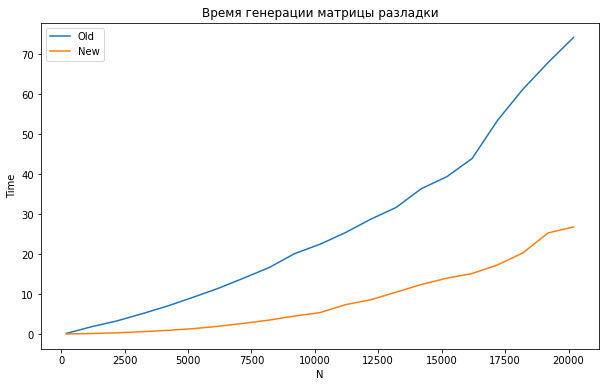

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(N_set, timesOld, label="Old")
plt.plot(N_set, timesNew, label="New")
plt.legend()
plt.title("Время генерации матрицы разладки")
plt.xlabel("N")
plt.ylabel("Time")
plt.savefig("report/tex/images/timetests.png")
plt.show()

In [20]:
print(np.array(timesOld)/np.array(timesNew))

[20.54195423 15.71123333 10.89718929  8.72011428  7.66871252  6.88320512
  5.91379503  5.23191689  4.77628567  4.47391332  4.20156448  3.45619532
  3.3560477   3.02416984  2.93384278  2.81887637  2.90102052  3.09228432
  3.01766889  2.68509513  2.7705045 ]


---

## Сравнение способов построения

In [20]:
def hmatrTestRowCol(ser, n):
    hmF = Hmatr(ser[:n], B, T_, L, neig=r, svdMethod=method)
    timesInside = []
    for i in range(len(ser)):
        tс = time.clock()
        hmF.update_hmatr(ser[i])
        timesInside.append(time.clock() - tс)
    return sum(timesInside)
    

def hmatrTestRow(ser, n):
    hmF = Hmatr_row(ser[:n], B, T_, L, neig=r, svdMethod=method)
    timesInside = []
    for i in range(len(ser)):
        tс = time.clock()
        hmF.update_hmatr(ser[i])
        timesInside.append(time.clock() - tс)
    return sum(timesInside)
        
    
def testAppending(ser = f):
    n = 200  
    t = time.clock()
    hmF = Hmatr_row(ser[:n], B, T_, L, neig=r, svdMethod=method)
    print(f"{time.clock() - t} - first {n} elements processed\n")
    
    timeRow = hmatrTestRow(ser, n)
    timeRowCol = hmatrTestRowCol(ser, n)
    
    appendLen = len(ser) - n
    
    avgtimeRow = timeRow / appendLen
    avgtimeRowCol = timeRowCol / appendLen
    
    print("Row:")
    print(f"\t{timeRow} - processed last {len(ser) - n} \n\t{timeRow/appendLen} - average for 1 row appending\n")
    
    print("Row and col:")
    print(f"\t{timeRowCol} - processed last {len(ser) - n} \n\t{timeRowCol/appendLen} - average for 1 row appending\n")
    
    print("Diffs (for all elements):")
    print(f"\tRow-(Row + Col): {round(timeRowCol - timeRow, 6)} sec\n")
    
    print("Diffs (avg for 1 element):")
    print(f"\tRow/(Row + Col) : {round(avgtimeRow/avgtimeRowCol * 100, 4)} % \n\tRow-(Row + Col): {round(avgtimeRowCol - avgtimeRow, 6)} sec\n")

In [21]:
testAppending(f)

0.15180880000116304 - first 200 elements processed

Row:
	0.9564988000001904 - processed last 200 
	0.004782494000000952 - average for 1 row appending

Row and col:
	12.210059199993339 - processed last 200 
	0.06105029599996669 - average for 1 row appending

Diffs (for all elements):
	Row-(Row + Col): 11.25356 sec

Diffs (avg for 1 element):
	Row/(Row + Col) : 7.8337 % 
	Row-(Row + Col): 0.056268 sec



In [22]:
testAppending(f1)

0.14094829999885405 - first 200 elements processed

Row:
	1.3795326999988902 - processed last 300 
	0.004598442333329634 - average for 1 row appending

Row and col:
	17.852223000005324 - processed last 300 
	0.059507410000017746 - average for 1 row appending

Diffs (for all elements):
	Row-(Row + Col): 16.47269 sec

Diffs (avg for 1 element):
	Row/(Row + Col) : 7.7275 % 
	Row-(Row + Col): 0.054909 sec



In [23]:
testAppending(f2)

0.15655880000122124 - first 200 elements processed

Row:
	1.981674099990414 - processed last 400 
	0.004954185249976035 - average for 1 row appending

Row and col:
	26.789212399986354 - processed last 400 
	0.06697303099996589 - average for 1 row appending

Diffs (for all elements):
	Row-(Row + Col): 24.807538 sec

Diffs (avg for 1 element):
	Row/(Row + Col) : 7.3973 % 
	Row-(Row + Col): 0.062019 sec



In [24]:
testAppending(f3)

0.1506837999986601 - first 200 elements processed

Row:
	2.3579886999887094 - processed last 500 
	0.004715977399977419 - average for 1 row appending

Row and col:
	34.02795629999855 - processed last 500 
	0.0680559125999971 - average for 1 row appending

Diffs (for all elements):
	Row-(Row + Col): 31.669968 sec

Diffs (avg for 1 element):
	Row/(Row + Col) : 6.9296 % 
	Row-(Row + Col): 0.06334 sec



In [25]:
testAppending(f4)

0.1950120000001334 - first 200 elements processed

Row:
	3.373522599986245 - processed last 600 
	0.0056225376666437414 - average for 1 row appending

Row and col:
	46.296910199951526 - processed last 600 
	0.07716151699991922 - average for 1 row appending

Diffs (for all elements):
	Row-(Row + Col): 42.923388 sec

Diffs (avg for 1 element):
	Row/(Row + Col) : 7.2867 % 
	Row-(Row + Col): 0.071539 sec



In [26]:
testAppending(f5)

0.17978930000026594 - first 200 elements processed

Row:
	4.154808599954777 - processed last 700 
	0.005935440857078252 - average for 1 row appending

Row and col:
	59.18102969995016 - processed last 700 
	0.08454432814278594 - average for 1 row appending

Diffs (for all elements):
	Row-(Row + Col): 55.026221 sec

Diffs (avg for 1 element):
	Row/(Row + Col) : 7.0205 % 
	Row-(Row + Col): 0.078609 sec



------

# Вывод

* Подсчет столбца увеличивает время заполнения матрицы разладки новым элементом на ~7%.
* Разница между последовательным заполнением матрицы разладки и однократным обуславливается дополнительными вычислениями (добавление нового элемента в ряд, лаг-вектора в траекторную матрицу, элемента кумулятивной суммы, а так же дополнительно заполнения нового столбца матрицы). 
* Дополнительные ~7%, затрачиваемые на дозаполнение матрицы обеспечивают, в сравнении с однократным заполнением, довольно долгое время заполнения в целом, однако добавление одного элемента довольно быстрое. В задаче достроения матрицы в режиме реального времени, при получении нового наблюдения добавление одного элемента предпочтительнее.